## Data Reduction of MQ-SCExAO Lab Spectrograph

### 7 cores single mode fiber input, oriented in rotation for maximum seperation in cross dispersion direction

#### Setup Notes

Using a ZWO ASI183MM CMOS camera as the detector


* Sensor type	CMOS
* Sensor specification	 1/3″ CMOS
* Pixel Size: 2.4µm
* Bit rate: 12bit output (12bit ADC)

The setups:

Using the inner 7 cores of a 19 core Single mode Multicore Fiber
laser cut brass aperture inserted between the ferrule and the FC/PC connector are masking the outer fiber

other end of the MCF has 3D nano printed microlenses and is couple to SCExAO

Spectrograph has an R4 grating, whihc is fed from a reimaging fiber input and collimated by a 200 mm ITL lens

cross dispersion is done by a 200 line/mm grating, some significant gamma angle

camera lens is another 200 mm TTL lens

Setup is non enclosed

### import the necessary packages

In [189]:
import matplotlib.pyplot as plt  
import pandas as pd  
import os
import numpy as np
from astropy.io import fits 

from PIL import Image


#conda install -c astropy photutils

from photutils import centroid_com, centroid_1dg, centroid_2dg

#need to install newer version of scipy from conda, need 1.2 or newer for find_peaks function

from scipy.signal import find_peaks

#for animations
from matplotlib import animation, rc
from IPython.display import HTML

#patches
from matplotlib import patches as patches

import ccdproc
from astropy.nddata import CCDData
import astropy.units as u

import os
import glob

### Set the pixel size for your detector
The ZWO ASI183MM camera 

In [190]:
pixelsize=2.4

### Set up data store directories

In [191]:
datastore_path="c:/cloudstor/datastore/SCExAO-MCF/"
proc_dir="processed/"
run_dir="16-10-2019/"
run_dir2="18-10-2019/"

### Collect filenames

In [192]:
#bias_files=["super-k-0001bias.fit","super-k-0002bias.fit","super-k-0003bias.fit"]

bias_files=glob.glob(os.path.join(datastore_path,run_dir,"super*bias*"))

print(bias_files)

#dark_files=["gamma-dark-480.fit","gamma-dark-480-2.fit"]

dark_files=glob.glob(os.path.join(datastore_path,run_dir,"*dark-300*"))

print(dark_files)


#flat_files=[datastore_path + run_dir + "super-k-flat-10.fit"]
flat_files=[datastore_path + run_dir2 + "halogen.fit"]


print(flat_files)

science_files=[datastore_path + run_dir + "gamma_1.fit"]

print(science_files)


['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0001bias.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0002bias.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0003bias.fit']
['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0001-dark-300-.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0002-dark-300-.fit', 'c:/cloudstor/datastore/SCExAO-MCF/16-10-2019\\super-k-0003-dark-300-.fit']
['c:/cloudstor/datastore/SCExAO-MCF/18-10-2019/halogen.fit']
['c:/cloudstor/datastore/SCExAO-MCF/16-10-2019/gamma_1.fit']


## I. Prepare Images

### Create Master bias

In [197]:
mb_filename=os.path.join(datastore_path,proc_dir,"masterbias.fit")

if os.path.exists(mb_filename) == False:
    mb_ccd = ccdproc.combine(bias_files,mb_filename,method="median",unit="adu")
else:
    mb_ccd = CCDData.read(mb_filename)  
    
    
#im = fits.open(mb_filename)
#mb_imarray=im[0].data


### Create Master dark and bias correct it

In [203]:
dk_filename=os.path.join(datastore_path,proc_dir,"masterdark.fit")
dark_exp = 300.0*u.second
flat_exp = 300.0*u.second
sci_exp = 480.0 * u.second


if os.path.exists(dk_filename) == False:
    darkcombined = ccdproc.combine(dark_files,method="median",unit="adu")
    dk_ccd = ccdproc.subtract_bias(darkcombined, mb_ccd)
    #hdulist = masterdark.to_hdu()
    dk_ccd.write(dk_filename,unit="adu")
else:
    dk_ccd = CCDData.read(dk_filename)
    
    
#im = fits.open(dk_filename)
#dk_imarray=im[0].data


flat_ccd = CCDData.read(flat_files[0],unit="adu")

### Preview the halogen flat, 300s exposure

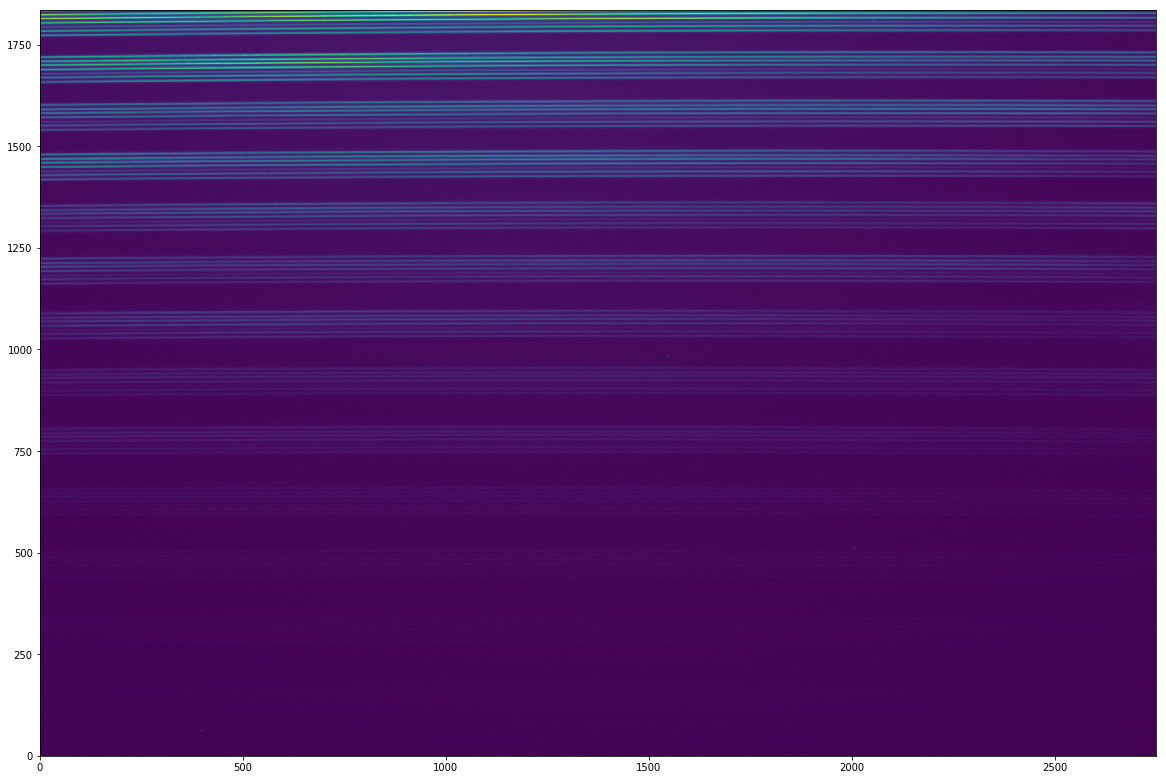

In [207]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(flat_ccd,origin='lower',cmap='viridis')

### Preview the science exposure

In [204]:
#im = fits.open(science_files[0])
#sci_imarray=im[0].data

sci_ccd = CCDData.read(science_files[0], unit="adu")

#Exposure is binned 2, 480 sec of Gamma gem, taken through SCExAO, 3dprinted MCF at highest observability

In [205]:
sci_ccd.shape

(1836, 2748)

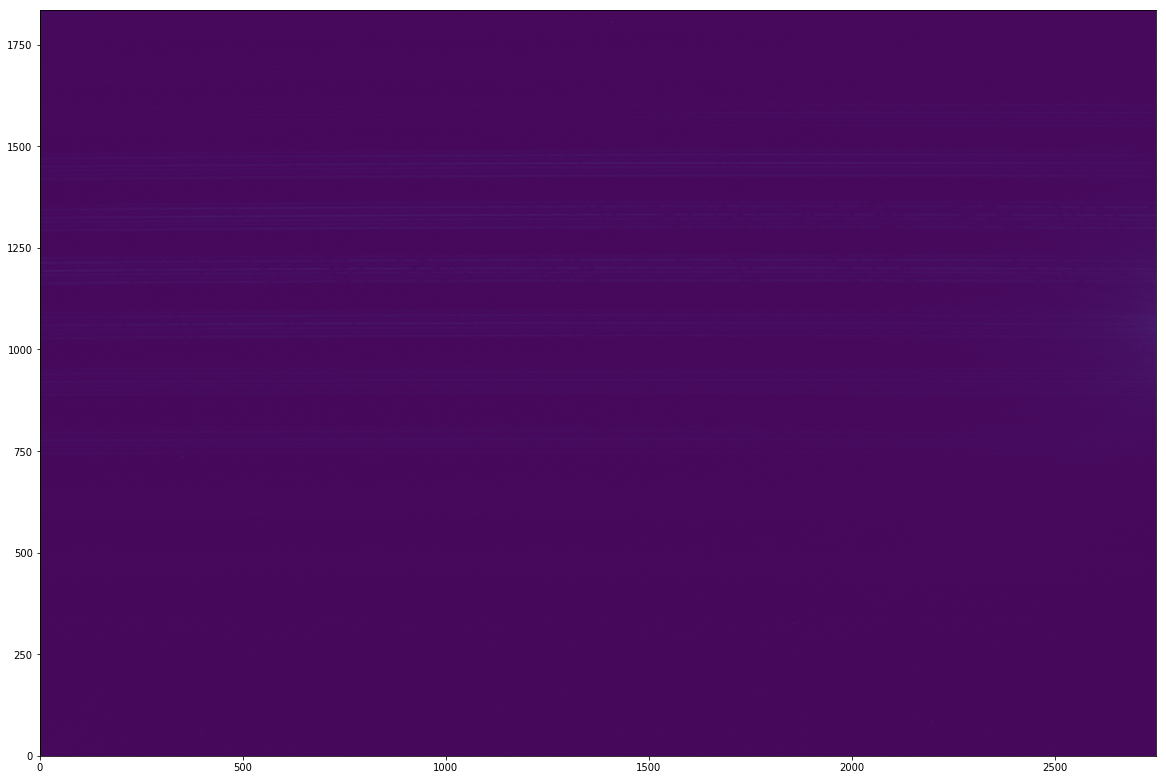

In [206]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(sci_ccd,origin='lower',cmap='viridis')

### Subtract Darks and Bias from flat exposure

In [210]:
#procflat = ccdproc.ccd_process(flat_ccd, master_bias = mb_ccd, dark_frame = dk_ccd, data_exposure = flat_exp, 
#                               dark_exposure = dark_exp, error=False, dark_scale = True, gain_corrected = False)

procflat = ccdproc.subtract_bias(flat_ccd, mb_ccd)
procflat = ccdproc.subtract_dark(procflat,dk_ccd, data_exposure = flat_exp, dark_exposure = dark_exp, scale = True)


### Subtract Darks and Bias from science exposure

In [212]:
#procsci = ccdproc.(sci_ccd, master_bias = procdark, data_exposure = sci_exp, dark_frame = dk_ccd, dark_exposure = dark_exp, 
#                                error=False, dark_scale = True, gain_corrected = False)

procsci = ccdproc.subtract_bias(sci_ccd, mb_ccd)
procsci = ccdproc.subtract_dark(procsci,dk_ccd, data_exposure = sci_exp, dark_exposure = dark_exp, scale = True)


### Plot the processed frames

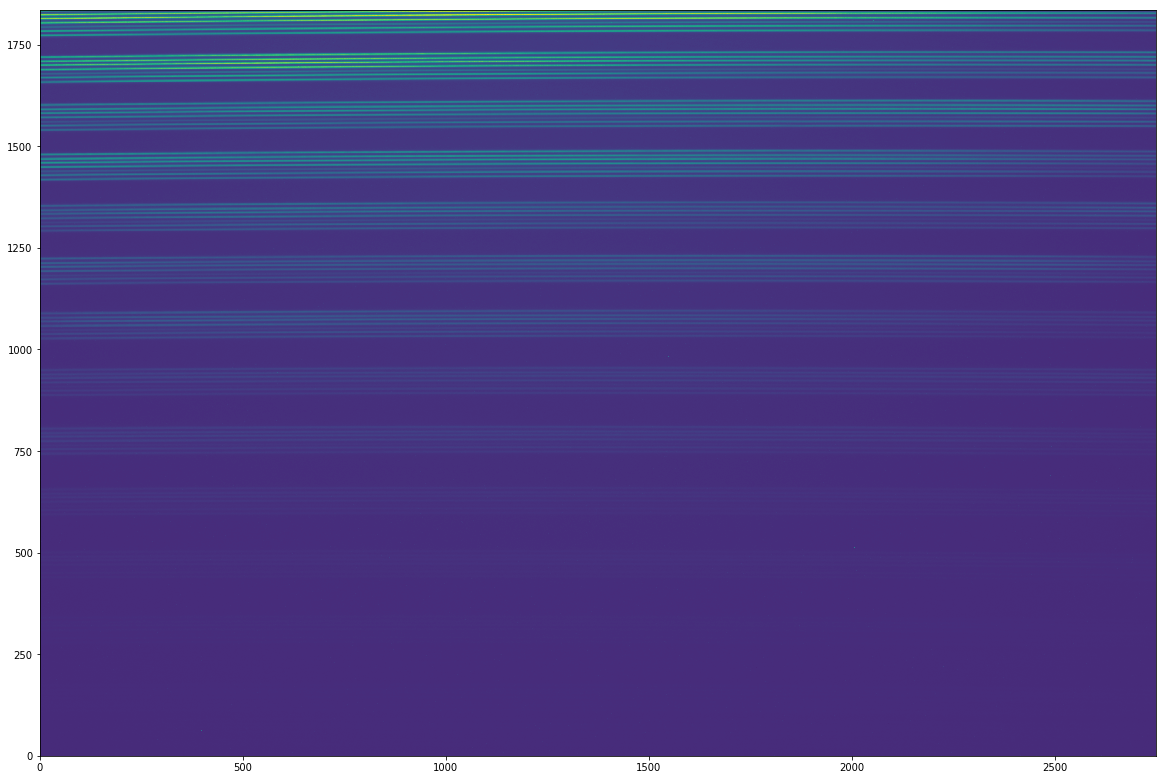

In [213]:
#flat.shape

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(procflat,origin='lower',cmap='viridis')

#procflat

[[-1188.8 -1224.8 -1145.6 ... -1193.6 -1128.  -1196. ]
 [-1232.  -1172.8 -1173.6 ... -1204.  -1108.  -1217.6]
 [-1120.8 -1262.4 -1192.  ... -1180.  -1204.8 -1136.8]
 ...
 [-1220.8 -1183.2 -1274.4 ... -1231.2 -1190.4 -1143.2]
 [-1275.2 -1264.  -1241.6 ... -1200.  -1149.6 -1134.4]
 [-1200.8 -1218.4 -1276.  ... -1196.8 -1173.6 -1185.6]]


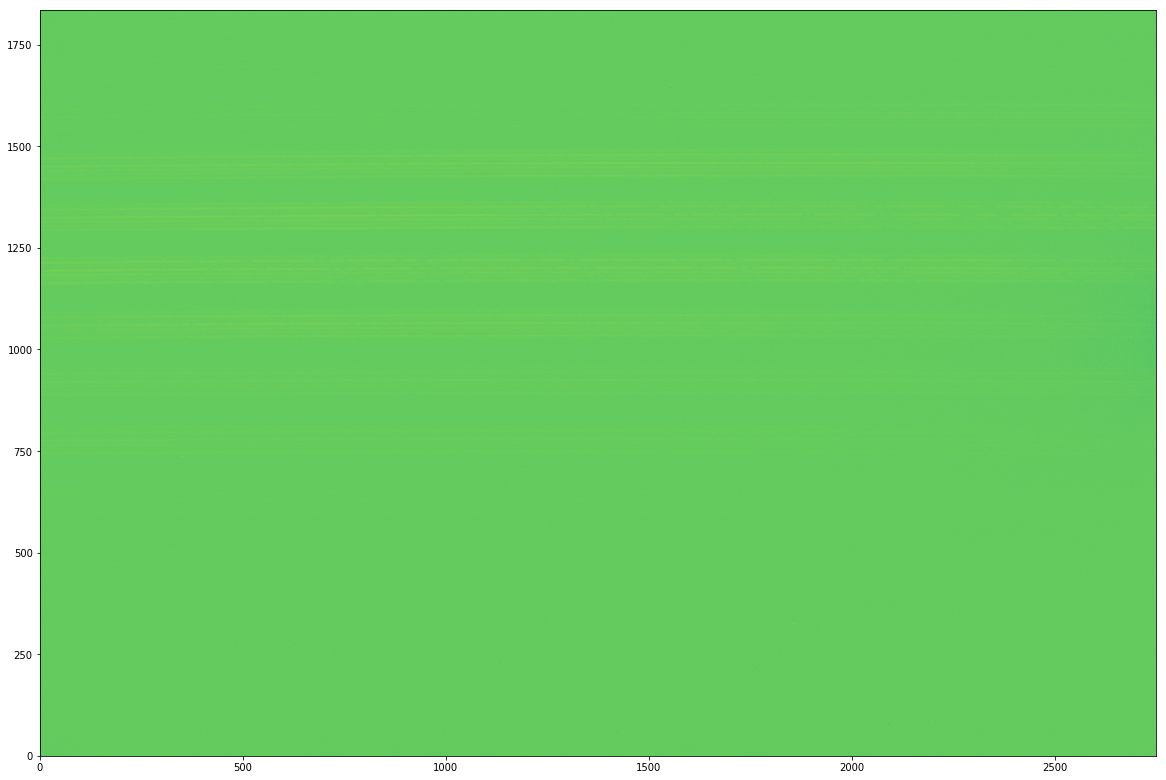

In [214]:
#flat.shape

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(procsci,origin='lower',cmap='viridis')

print(procsci)

#procflat

### Set a box to evaluate a section of the frame

In [35]:
## pick a coordinate for the lower left coordinate of the rectangle
#xorigin=(0,250)
xorigin=(0,500)


##no need to chance these, picking a different width will slow down the animation generation
## the height will cover about 3-4 cross dispersions of the MCF
xwidth=2748
yheight=90

### Show the selection on the frame

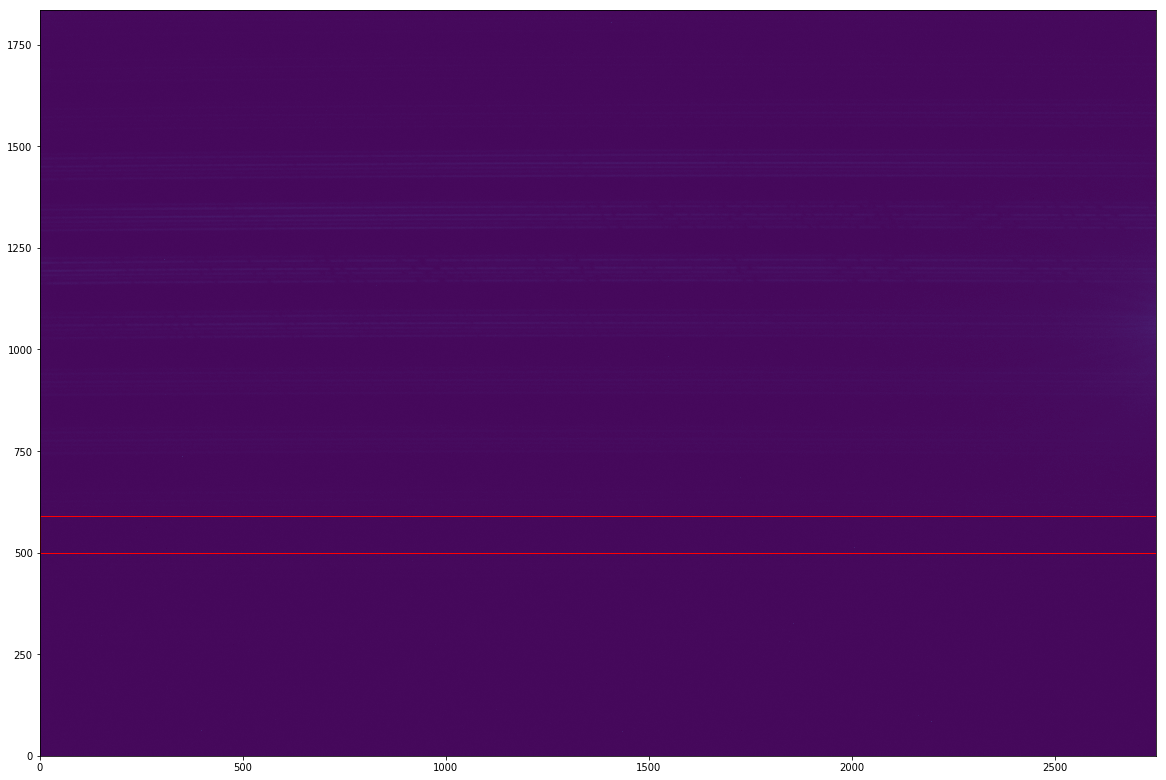

In [32]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(imarray,origin='lower',cmap='viridis')

#rect=plt.Rectangle((0, 0), 1, 1, color='r')
# Create a Rectangle patch
rect = patches.Rectangle(xorigin,xwidth,yheight,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

### Plot the chosen segment from the detector frame

In [68]:
cropimg=imarray[xorigin[1]:xorigin[1]+yheight,xorigin[0]:xorigin[0]+xwidth]
cropimg.shape

(90, 4656)

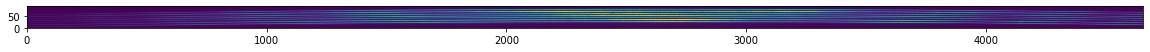

In [69]:
plt.figure(figsize=(20, 20))
plt.imshow(cropimg,origin='lower')
plt.savefig("selection-mcf.png", bbox_inches="tight")

### Determin the max and min values in the selection

Needed to set the frame in the animation and graph

In [70]:
maxval=np.amax(cropimg)+50

In [71]:
minval=np.amin(cropimg)-50

In [72]:
print(minval)
print(maxval)

574
35314


### Determine the peaks in the strip using scipy.signal find_peaks function

In [73]:
#extract 600 rows of the 100th column, which should contain about 4 cross dispersion line bundles

column_peaks = []
column_peaks_intensity = []
which_mcf = 3

#y, _ = find_peaks(cropimg[:,0], height=200,distance=7)
for i in range(xwidth):
    y, _ = find_peaks(cropimg[:,i], height=950,distance=6)
    column_peaks.append(y)
    column_peaks_intensity.append(cropimg[y[which_mcf],i])
    #print(y)
    
#column_peaks.count

column_peaks = np.array(column_peaks)
column_peaks_intensity = np.array(column_peaks_intensity)
#print(column_peaks_intensity)

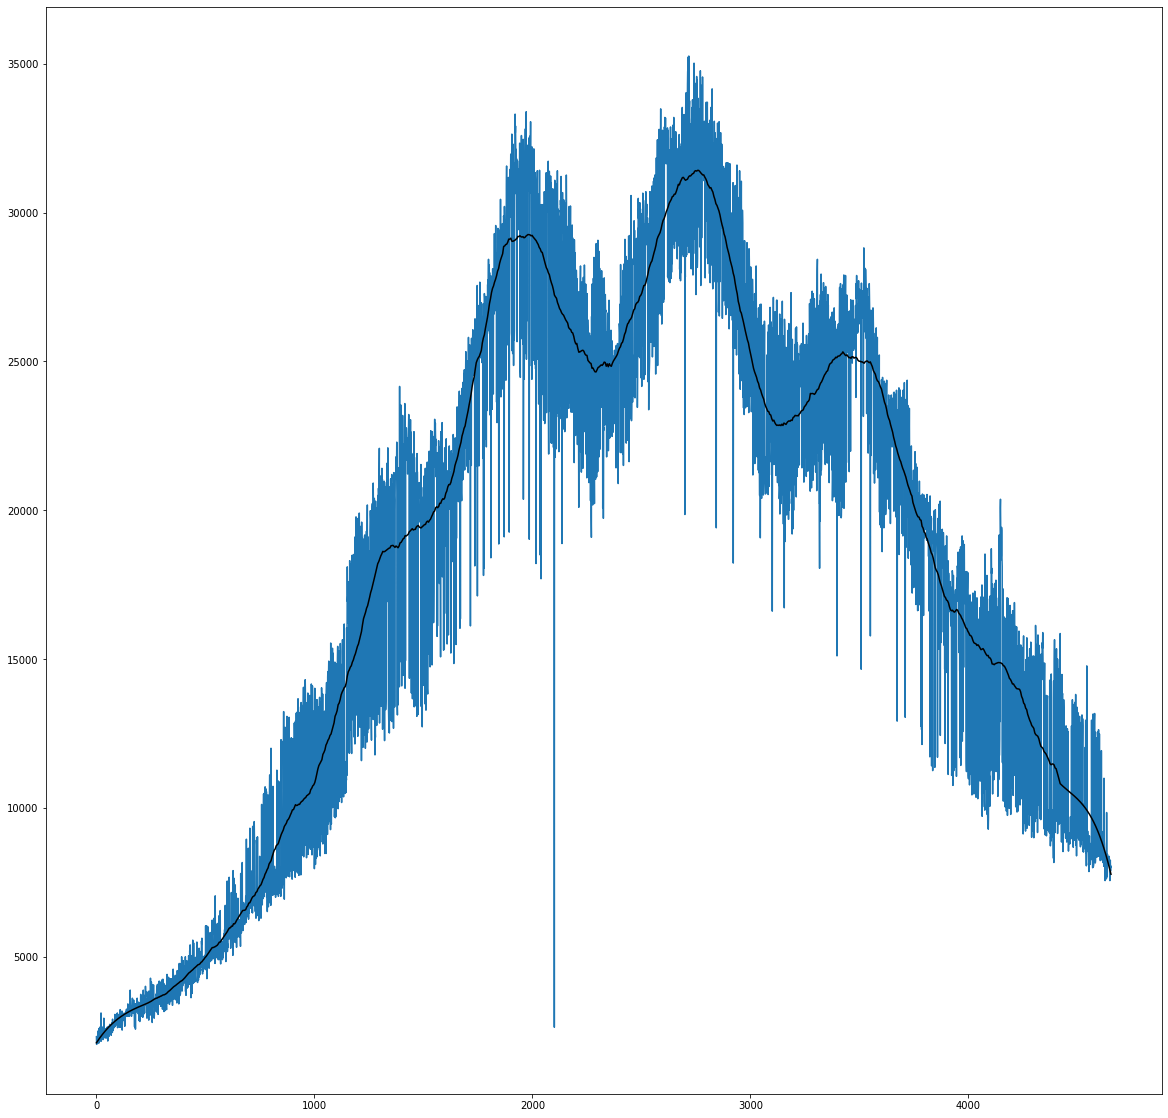

In [74]:
#cropimg[:,400]

#column_peaks.shape

#print(column_peaks)

#column_peaks_intensity.shape

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

x = np.array(range(xwidth))

xx = np.linspace(x.min(),x.max(), 1000)

#print(xx)

itp = interp1d(range(xwidth),column_peaks_intensity, kind='linear')
window_size, poly_order = 101, 3
yy_sg = savgol_filter(itp(xx), window_size, poly_order)

plt.figure(figsize=(20, 20))
plt.plot(column_peaks_intensity)
plt.plot(xx,yy_sg,'k', label= "Smoothed curve")

### Calculate the distance peak to peak, pad a 0 at the end

In [75]:
x=np.append(np.diff(y),0)

In [76]:
z=cropimg[y,0]
print(z)

[1824 2240 2000 2016 1776 2336 1680  832  816  848]


### I. plot the first pixel column in the strip being examine

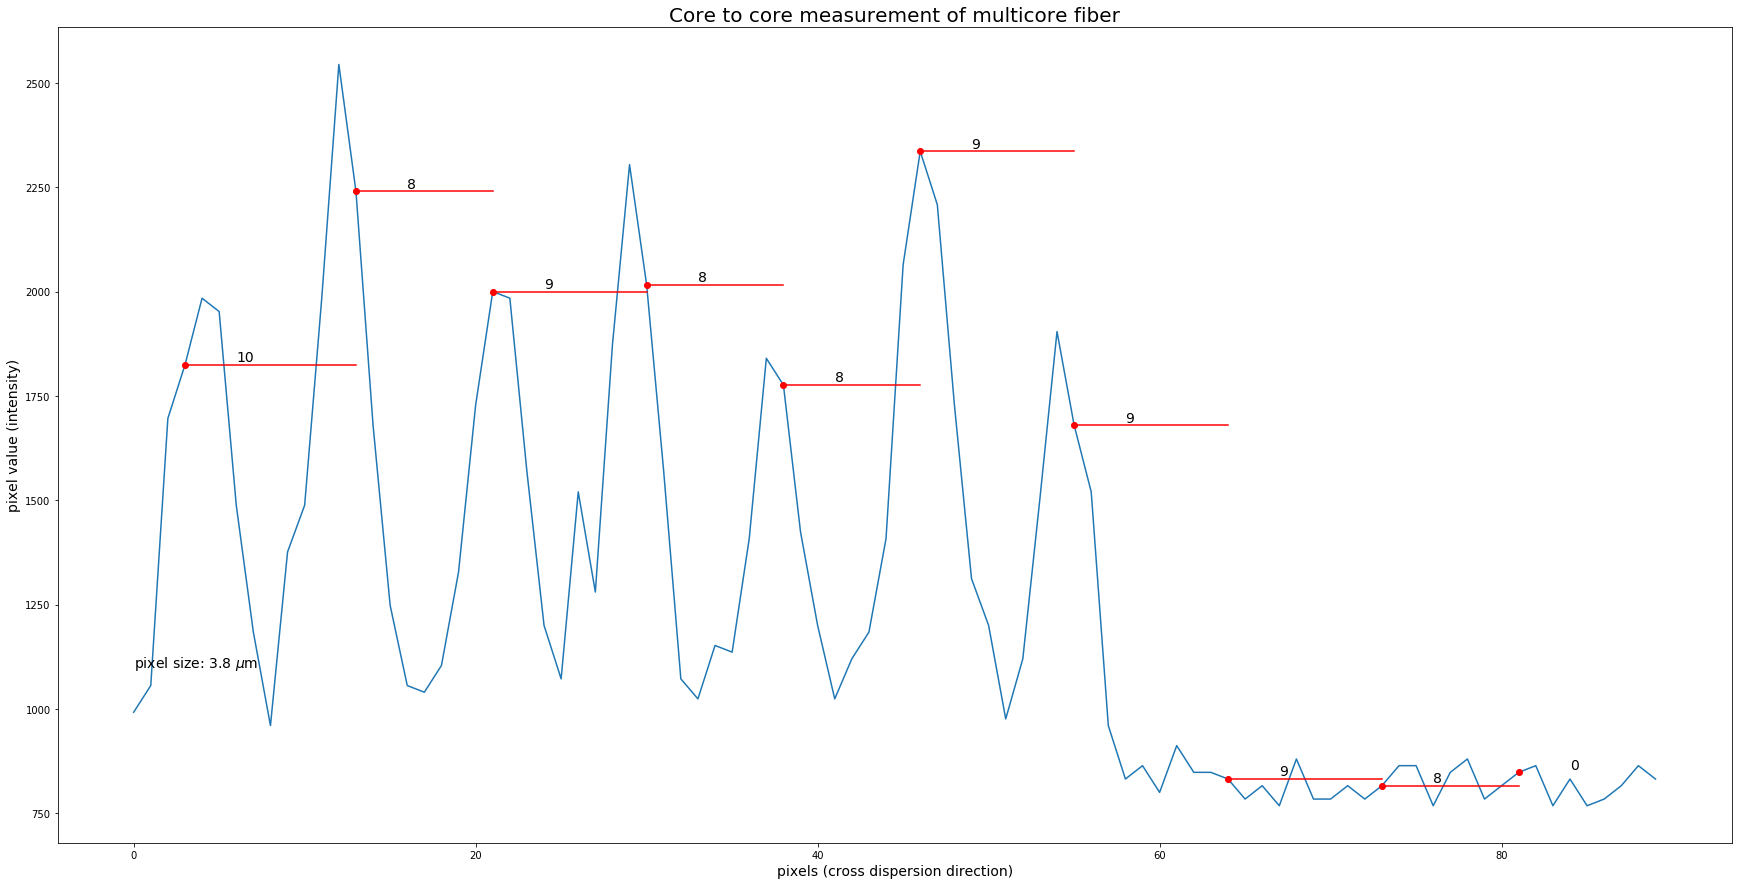

In [77]:
plt.figure(figsize=(30, 15))

plt.plot(cropimg[:,0])
plt.plot(y,z,'ro')
for i, txt in enumerate(x):
    plt.annotate(txt,(y[i]+3,z[i]+8),fontsize=14)
    plt.plot((y[i],y[i]+txt),(z[i],z[i]),'r')
plt.title("Core to core measurement of multicore fiber",fontsize=20)
plt.xlabel("pixels (cross dispersion direction)",fontsize=14)
plt.ylabel("pixel value (intensity)",fontsize=14)
plt.annotate('pixel size: ' + str(pixelsize) + ' $\mu$m',(0,1100),fontsize=14)

plt.savefig("core2core-mcf.png", bbox_inches="tight")

In [33]:
import ccdproc

ModuleNotFoundError: No module named 'ccdproc'